In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from eegatscale.models import LinearHeadBENDR
from eegatscale.transforms import Standardize
from scipy.stats import ttest_ind
import torch
import tqdm

from captum.concept import TCAV, Concept
from captum.concept._utils.common import concepts_to_str
from concept_classifier import TCAVClassifier
import warnings
warnings.filterwarnings("ignore")

from dataset_utils import Experiment

In [2]:
concepts_dir = '/scratch/s194101/concepts/'

print(list(os.listdir(concepts_dir)))



['random_mmidb_alpha_no_baseline_lh', 'random_tuh_alpha', 'sanity_check_concepts_MMIDB_alpha_no_baseline', 'random_mmidb_gamma_no_baseline_rh', 'random_mmidb_alpha_lh', 'random_right_concept_MMIDB_Alpha_sanity_check', 'TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124', 'random_mmidb_alpha_rh', 'random_right_concept_MMIDB_Alpha_sanity_check_1000', 'TUSZ', 'random_mmidb_gamma_no_baseline_lh', 'random_tuh_alpha_1000', 'random_mmidb_alpha_no_baseline_rh', 'sanity_check_concepts_MMIDB_all_no_baseline', 'TUEV', 'sanity_check_concepts_MMIDB_all_baseline', 'random_mmidb_alpha_no_baseline_T0_lh', 'TUH_clean_all_subtract_Truesigma_Trueabs_100.0_135454_131124', 'random_left_concept_MMIDB_Alpha_sanity_check', 'random_left_concept_MMIDB_Alpha_sanity_check_1000', 'random_tuh_all', 'random_tuh_all_1000', 'random_mmidb_alpha_no_baseline_T0_rh']


## load model

In [3]:
out_features = 2
# encoder_path = "/scratch/agjma/checkpoints/tuh-noica-standardize-epoch=9-step=68317-val_loss=0.26.ckpt"
encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt"

model = LinearHeadBENDR(encoder_path, encoder_h=512, in_features=19, out_features=out_features)
state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))["state_dict"]
model.load_state_dict(state_dict)
model.eval()
print("model loaded")

Initialized mask embedding and position encoder from  /scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt
model loaded


In [4]:
# exp_1 = Experiment(model,
#                 "random_left_concept_MMIDB_Alpha",
#                 concepts_dir,
#                 ["left_right_concepts_MMIDB/Alpha_lh",
#                  "random_mmidb_labeled"],
#                  verbose=True,
#                  n_runs=100,)
# exp_2 = Experiment(model,
#                 "random_left_concept_MMIDB_Alpha",
#                 concepts_dir,
#                 ["random_left_concept_MMIDB_Alpha",
#                  "random_mmidb_labeled"],
#                  verbose=True,
#                  n_runs=100,
#                  internal_concept_idx=1000)

# exp_3 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha",
#                    concepts_dir,
#                    ["left_right_concepts_MMIDB/Alpha_rh",
#                     "random_mmidb_labeled"],
#                     verbose=True,
#                     n_runs=100,
#                     internal_concept_idx=2000)

# exp_4 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha",
#                    concepts_dir,
#                    ["random_right_concept_MMIDB_Alpha",
#                     "random_mmidb_labeled"],
#                     verbose=True,
#                     n_runs=100,
#                     internal_concept_idx=3000)
# exp_1 = Experiment(model,
#                 "random_left_concept_MMIDB_Alpha",
#                 concepts_dir,
#                 ["random_left_concept_MMIDB_Alpha",
#                 "left_right_concepts_MMIDB/Alpha_lh",
#                  "left_right_concepts_MMIDB/Alpha_rh",
#                  "random_right_concept_MMIDB_Alpha",
#                  ],
#                  verbose=True,
#                  n_runs=100,)

# exp_1 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha_sanity_check",
#                    concepts_dir,
#                    ["random_left_concept_MMIDB_Alpha_sanity_check",
#                     "random_mmidb_alpha_new"],
#                     verbose=True,
#                     n_runs=100,
#                     n_concept_samples=75,
#                     batch_size=1,
#                     internal_concept_idx=0)

# exp_2 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha_sanity_check",
#                    concepts_dir,
#                    ["random_right_concept_MMIDB_Alpha_sanity_check",
#                     "random_mmidb_alpha_new"],
#                     verbose=True,
#                     n_runs=100,
#                     n_concept_samples=75,
#                     batch_size=1,
#                     internal_concept_idx=1000)
# exp_3 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha_sanity_check",
#                    concepts_dir,
#                    ["sanity_check_concepts_MMIDB_alpha_new/Alpha_Somatosensory and Motor Cortex-lh",
#                     "random_mmidb_alpha_new"],
#                     verbose=True,
#                     n_runs=100,
#                     n_concept_samples=75,
#                     batch_size=1,
#                     internal_concept_idx=2000)
# exp_4 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha_sanity_check",
#                    concepts_dir,
#                    ["sanity_check_concepts_MMIDB_alpha_new/Alpha_Somatosensory and Motor Cortex-rh",
#                     "random_mmidb_alpha_new"],
#                     verbose=True,
#                     n_concept_samples=75,
#                     n_runs=100,
#                     batch_size=1,
#                     internal_concept_idx=3000)



####
# exp_5 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha_sanity_check",
#                    concepts_dir,
#                    ["random_left_concept_MMIDB_Alpha_sanity_check",
#                     "random_tuh_alpha"],
#                     verbose=True,
#                     n_concept_samples=200,
#                     n_runs=100,
#                     batch_size=4,
#                     internal_concept_idx=4000)
# exp_6 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha_sanity_check",
#                    concepts_dir,
#                    ["random_right_concept_MMIDB_Alpha_sanity_check",
#                     "random_tuh_alpha"],
#                     verbose=True,
#                     n_concept_samples=200,
#                     n_runs=100,
#                     batch_size=4,
#                     internal_concept_idx=5000)
# exp_7 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha_sanity_check",
#                    concepts_dir,
#                    ["sanity_check_concepts_MMIDB_alpha/Alpha_Somatosensory and Motor Cortex-lh",
#                     "random_tuh_alpha"],
#                     verbose=True,
#                     n_concept_samples=75,
#                     n_runs=100,
#                     batch_size=4,
#                     internal_concept_idx=6000)
# exp_8 = Experiment(model,
#                    "random_left_concept_MMIDB_Alpha_sanity_check",
#                    concepts_dir,
#                    ["sanity_check_concepts_MMIDB_alpha/Alpha_Somatosensory and Motor Cortex-rh",
#                     "random_tuh_alpha"],
#                     verbose=True,
#                     n_concept_samples=75,
#                     n_runs=100,
#                     batch_size=4,
#                     internal_concept_idx=7000)

# experiments = [exp_5, exp_6, exp_7, exp_8]
# experiments = [exp_1, exp_2, exp_3, exp_4]
# experiments = [exp_1]

In [5]:
target_data = "random_left_concept_MMIDB_Alpha_sanity_check"
# random_concept = "random_mmidb_alpha_new"
random_concept = "random_tuh_alpha_1000"

concept_dir_names = [
    "random_left_concept_MMIDB_Alpha_sanity_check",
    "random_right_concept_MMIDB_Alpha_sanity_check",
    # "random_mmidb_alpha_lh",
    # "random_mmidb_alpha_no_baseline_lh",
    # "random_mmidb_alpha_no_baseline_T0_lh",
    "random_mmidb_gamma_no_baseline_lh",
    # "random_mmidb_alpha_rh",
    # "random_mmidb_alpha_no_baseline_rh",
    # "random_mmidb_alpha_no_baseline_T0_rh",
    "random_mmidb_gamma_no_baseline_rh",
    ]
# concept_dir_names = [
#     "sanity_check_concepts_MMIDB_alpha_new/Alpha_Premotor Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_new/Alpha_Premotor Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_new/Alpha_Somatosensory and Motor Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_new/Alpha_Somatosensory and Motor Cortex-rh",
#     ]
# concept_dir_names = [
#     "sanity_check_concepts_MMIDB_alpha_new/Alpha_Early Visual Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_new/Alpha_Early Visual Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_new/Alpha_Primary Visual Cortex (V1)-lh",
#     "sanity_check_concepts_MMIDB_alpha_new/Alpha_Primary Visual Cortex (V1)-rh",
#     ]
experiments = []
idx = 0
for concept_dir_name in concept_dir_names:
    exp = Experiment(model,
                    target_data,
                    concepts_dir,
                    [
                    concept_dir_name, # this is where you add extra concepts, (in the square brackets)
                    random_concept,
                    ],
                    verbose=True,
                    n_concept_samples=75,
                    n_runs=100,
                    internal_concept_idx=idx)
    experiments.append(exp)
    idx += 1000

Loaded dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_tuh_alpha_1000 with 1000 samples
Loaded input dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_right_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_tuh_alpha_1000 with 1000 samples
Loaded input dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_mmidb_gamma_no_baseline_lh with 200 samples
Loaded dataset random_tuh_alpha_1000 with 1000 samples
Loaded input dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_mmidb_gamma_no_baseline_rh with 200 samples
Loaded dataset random_tuh_alpha_1000 with 1000 samples
Loaded input dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples


In [6]:
experiments[0].internal_concept_idx

200

In [7]:
for concept_name, concepts in experiments[0].concepts.items():
    print(concept_name)
    print(concepts)
    break

random_left_concept_MMIDB_Alpha_sanity_check
[Concept(0, 'random_left_concept_MMIDB_Alpha_sanity_check_000'), Concept(1, 'random_left_concept_MMIDB_Alpha_sanity_check_001'), Concept(2, 'random_left_concept_MMIDB_Alpha_sanity_check_002'), Concept(3, 'random_left_concept_MMIDB_Alpha_sanity_check_003'), Concept(4, 'random_left_concept_MMIDB_Alpha_sanity_check_004'), Concept(5, 'random_left_concept_MMIDB_Alpha_sanity_check_005'), Concept(6, 'random_left_concept_MMIDB_Alpha_sanity_check_006'), Concept(7, 'random_left_concept_MMIDB_Alpha_sanity_check_007'), Concept(8, 'random_left_concept_MMIDB_Alpha_sanity_check_008'), Concept(9, 'random_left_concept_MMIDB_Alpha_sanity_check_009'), Concept(10, 'random_left_concept_MMIDB_Alpha_sanity_check_010'), Concept(11, 'random_left_concept_MMIDB_Alpha_sanity_check_011'), Concept(12, 'random_left_concept_MMIDB_Alpha_sanity_check_012'), Concept(13, 'random_left_concept_MMIDB_Alpha_sanity_check_013'), Concept(14, 'random_left_concept_MMIDB_Alpha_sanity_ch

In [8]:
experiments[0].concept_names[0]

'random_left_concept_MMIDB_Alpha_sanity_check'

In [9]:
# for concept_name, concepts in experiments[0].concepts.items():
#     print(concept_name)
#     print(concepts)
#     for concept in concepts:
#         print(next(iter(concept.data_iter)).shape)
#         print(next(iter(concept.data_iter))[0,0])

# experiments[0].concepts.values()

In [10]:
layers = ["encoder", "enc_augment", "summarizer", "extended_classifier", "clf"]

def run_tcav(experiment:Experiment, layers:list):
    if "/" in experiment.concept_names[0]:
        save_path = f"/scratch/s194101/temp/cav/{experiment.concept_names[0].split('/')[-1]}/"
    else:
        save_path = f"/scratch/s194101/temp/cav/{experiment.concept_names[0]}/"
    tcav = TCAV(model, layers, model_id="BendrModel", classifier=TCAVClassifier(), save_path=save_path)
    # tcav = TCAV(model, layers, save_path=save_path)
    tcav_scores = tcav.interpret(inputs=experiment.inputs, experimental_sets=experiment.experimental_sets, target=0)
    tcav_scores = dict(tcav_scores)

    save_path = f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0].split('/')[-1]}.pkl" if "/" in experiment.concept_names[0] else f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0]}.pkl"
    with open(save_path, "wb") as f:
        pickle.dump(
            {"tcav_scores": tcav_scores,
             "experimental_sets": experiment.experimental_sets,},f)
    return tcav_scores
        

In [11]:
tcav = TCAV(model, layers, model_id="BendrModel", classifier=TCAVClassifier(), save_path="/scratch/s194101/temp/cav_test/")
tmp_scores = tcav.interpret(inputs=experiments[0].inputs, experimental_sets=[experiments[0].experimental_sets[0], experiments[1].experimental_sets[0]], target=0)


In [12]:
tmp_scores

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-100': defaultdict(None,
                         {'encoder': {'sign_count': tensor([0.8400, 0.1600]),
                           'magnitude': tensor([ 0.1042, -0.1042])},
                          'enc_augment': {'sign_count': tensor([0.9933, 0.0067]),
                           'magnitude': tensor([ 1.5972, -1.5972])},
                          'summarizer': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 4.9144, -4.9144])},
                          'extended_classifier': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 2.0743, -2.0743])},
                          'clf': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 0.6551, -0.6551])}}),
             '1000-1100': defaultdict(None,
                         {'encoder': {'sign_count': tensor([0.0133, 0.9867]),
                         

In [13]:
experiments[1].experimental_sets[0]

[Concept(1000, 'random_right_concept_MMIDB_Alpha_sanity_check_000'),
 Concept(1100, 'random_tuh_alpha_1000_000')]

In [14]:
experiments[0].experimental_sets[0]

[Concept(0, 'random_left_concept_MMIDB_Alpha_sanity_check_000'),
 Concept(100, 'random_tuh_alpha_1000_000')]

In [15]:
for exp in experiments:
    run_tcav(exp, layers)
    print(exp.inputs_name, exp.concept_names[0])

random_left_concept_MMIDB_Alpha_sanity_check random_left_concept_MMIDB_Alpha_sanity_check
random_left_concept_MMIDB_Alpha_sanity_check random_right_concept_MMIDB_Alpha_sanity_check
random_left_concept_MMIDB_Alpha_sanity_check random_mmidb_gamma_no_baseline_lh
random_left_concept_MMIDB_Alpha_sanity_check random_mmidb_gamma_no_baseline_rh


In [16]:
all_experimental_sets = []
all_tcav_scores = []

for i, exp in enumerate(experiments):
    file_path = f"/home/s194101/Bachelors-explainability/{exp.inputs_name}_{exp.concept_names[0].split('/')[-1]}.pkl" if "/" in exp.concept_names[0] else f"/home/s194101/Bachelors-explainability/{exp.inputs_name}_{exp.concept_names[0]}.pkl"
    with open(file_path, "rb") as f:
        data = pickle.load(f)
        all_tcav_scores.append(data["tcav_scores"])
        all_experimental_sets.append(data["experimental_sets"])

In [17]:
from plot_utils import assemble_scores, plot_tcav_scores

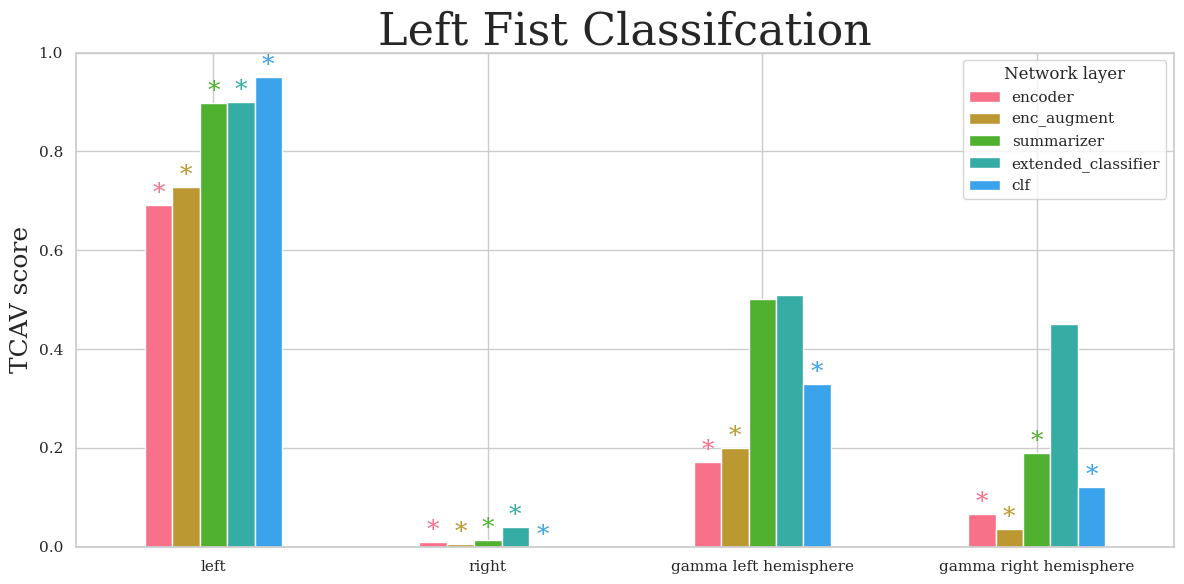

,encoder,enc_augment,summarizer,extended_classifier,clf
left,0.365756,0.358738,0.214667,0.300000,0.217945
right,0.049335,0.059710,0.080150,0.195959,0.000000
gamma left hemisphere,0.300286,0.322820,0.390739,0.499900,0.470213
gamma right hemisphere,0.191624,0.136449,0.297951,0.497494,0.324962


In [18]:
# concept_names = ["left", "right", "alpha left hemisphere", "alpha right hemisphere"]
concept_names = ["left", "right", "gamma left hemisphere", "gamma right hemisphere"]
# concept_names = ["Premotor Cortex-lh", "Premotor Cortex-rh", "Somatosensory and Motor Cortex-lh", "Somatosensory and Motor Cortex-rh"]
# concept_names = ["Early Visual Cortex-lh", "Early Visual Cortex-rh", "Primary Visual Cortex-lh", "Primary Visual Cortex-rh"]
title = "Left Fist Classifcation"
plt_name = "left_fist_prediction_gamma_0.01_10000"
# plt_name = "left_fist_prediction_anatomical_alpha_premotor_somatosensory"
# plt_name = "left_fist_prediction_anatomical_alpha_visual"

scores_mean_df, scores_std_df = plot_tcav_scores(all_experimental_sets, all_tcav_scores, concept_names=concept_names, title=title, score_type="sign_count", alpha=0.05, only_significant=False, with_error=False, plt_name=plt_name, file_type="png")
# scores_mean_df
scores_std_df


In [19]:
# all_tcav_scores[2]
assemble_scores(all_tcav_scores[1], all_experimental_sets[1], 0, "encoder", "sign_count")

array([0.00666667, 0.        , 0.        , 0.        , 0.        ,
       0.00666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00666667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.32      ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01333333, 0.        , 0.        ,
       0.01333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00666667, 0.        , 0.        ,
       0.04666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04666667, 0.        , 0.        , 0.        , 0.     

In [20]:
# all_tcav_scores[1]
# all_experimental_sets[1]

In [21]:
# all_experimental_sets[2]